In [3]:
import os,sys 
import pandas as pd
import numpy as np
#import seaborn as sns 
import glob
import geopandas as gpd
from fitparse import FitFile 

# Load data

In [7]:
STR_PATH_ACTIVITIES = r"D:\personal\running\GarminData\ACTIVITY"

In [8]:
def load_df_runs(path_activities): 
    activities = glob.glob(os.path.join(path_activities,"*.FIT"))
    activities.sort(key=os.path.getmtime)
    df_runs =  pd.concat([(pd.DataFrame([record.get_values() for record in fitfile.get_messages('record')])
                           .assign(**{"id_run": i})
                          )
                      for i,fitfile in enumerate([FitFile(fname) for fname in activities])],
                      sort=False 
                     )
    return df_runs.set_index(['id_run', 'timestamp'])

In [9]:
df_runs = load_df_runs(STR_PATH_ACTIVITIES)
df_runs.head()

position_lat  position_long  distance  \
id_run timestamp                                                    
0      2019-01-16 18:12:18   613786008.0     84689108.0      2.02   
       2019-01-16 18:12:19   613786062.0     84689070.0      2.02   
       2019-01-16 18:12:21   613786221.0     84688886.0      3.66   
       2019-01-16 18:12:24   613786307.0     84687551.0      3.66   
       2019-01-16 18:12:30   613785216.0     84684324.0     25.22   

                            enhanced_altitude  altitude  enhanced_speed  \
id_run timestamp                                                          
0      2019-01-16 18:12:18               96.0      96.0           2.025   
       2019-01-16 18:12:19               95.2      95.2           0.000   
       2019-01-16 18:12:21               95.0      95.0           0.000   
       2019-01-16 18:12:24               95.0      95.0           2.482   
       2019-01-16 18:12:30               95.2      95.2           3.695   

                            speed  unknown_88  heart_rate  cadence  \
id_run timestamp                                                     
0      2019-01-16 18:12:18  2.025       300.0        90.0      0.0   
       2019-01-16 18:12:19  0.000       300.0        90.0      0.0   
       2019-01-16 18:12:21  0.000       300.0        90.0      0.0   
       2019-01-16 18:12:24  2.482       300.0        90.0      0.0   
       2019-01-16 18:12:30  3.695       300.0        92.0     80.0   

                            fractional_cadence  rrhr  rawHR RRint  hrv  loc  \
id_run timestamp                                                              
0      2019-01-16 18:12:18                 0.0   NaN    NaN   NaN  NaN  NaN   
       2019-01-16 18:12:19                 0.0   NaN    NaN   NaN  NaN  NaN   
       2019-01-16 18:12:21                 0.0   NaN    NaN   NaN  NaN  NaN   
       2019-01-16 18:12:24                 0.0   NaN    NaN   NaN  NaN  NaN   
       2019-01-16 18:12:30                 0.5   NaN    NaN   NaN  NaN  NaN   

                           rmssd sdnn  
id_run timestamp                       
0      2019-01-16 18:12:18   NaN  NaN  
       2019-01-16 18:12:19   NaN  NaN  
       2019-01-16 18:12:21   NaN  NaN  
       2019-01-16 18:12:24   NaN  NaN  
       2019-01-16 18:12:30   NaN  NaN

In [10]:
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

def transform_coordinates(df_runs): 
    return df_runs.assign(**{'x_latlon':df_runs['position_long'] *180.0/(2**31),
                             'y_latlon':df_runs['position_lat'] * 180.0/(2**31)
                            }
                         )

def df_to_gdf(df_runs): 
    df_runs = transform_coordinates(df_runs)
    df_runs['geometry'] = list(zip(df_runs['x_latlon'], df_runs['y_latlon']))
    df_runs['geometry'] = df_runs['geometry'].apply(Point)
    return gpd.GeoDataFrame(df_runs, crs={'init' :'epsg:4326'})


def calc_cumulative_time(df_runs): 
    df_runs['cumulative_time_seconds'] = 0
    return df_runs.assign(cumulative_time_seconds=df_runs.groupby('id_run')[['cumulative_time_seconds']]
                          .transform(lambda x: np.hstack((np.zeros(1), 
                                                                np.cumsum((np.diff(x.index.get_level_values(level=1)))/ np.timedelta64(1, 's')))))
                         )

def apply_fastest_intervall(df, distance=1000): 
    idx_next_intervall = ((df['distance']+distance).values[:,None]>df['distance'].values).argmin(axis=1)
    fastest_splits = (df['cumulative_time_seconds'].values[idx_next_intervall]
                      -df['cumulative_time_seconds'].values[np.arange(idx_next_intervall.shape[0])])
    fastest_splits[fastest_splits<=0] = np.nan
    return fastest_splits


def calc_splits(df_runs, splits={'split_1k':1000.0, 'split_1mile': 1609.34}): 
    gb = df_runs.groupby("id_run")     
    return df_runs.assign(**{col_name: fast_stack(pd.DataFrame(gb.apply(apply_fastest_intervall, (distance)),
                                                                 columns=[col_name]),
                                                    col_values_list=col_name)[col_name].values for col_name, distance in splits.items()})
    

def fast_stack(df, col_id=None, col_values_list=None, n_per_list=None, data_unstacked=None):

    col_values_list = col_values_list or "values_list"
    if col_id is None:
        col_id_values = df.index.values
        col_id = "index"
    else:
        col_id_values = df[col_id].values

    if n_per_list is None:
        n_per_list = df.apply(lambda x: len(x[col_values_list]), axis=1).values
    return pd.DataFrame({col_id: np.repeat(col_id_values, n_per_list),
                         col_values_list: np.hstack(df[col_values_list].values)})

 

df_runs = df_to_gdf(df_runs)
df_runs = calc_cumulative_time(df_runs)
df_runs = calc_splits(df_runs)
df_runs.head()

C:\Users\nblo\anaconda3\envs\mega\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\nblo\anaconda3\envs\mega\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


position_lat  position_long  distance  \
id_run timestamp                                                    
0      2019-01-16 18:12:18   613786008.0     84689108.0      2.02   
       2019-01-16 18:12:19   613786062.0     84689070.0      2.02   
       2019-01-16 18:12:21   613786221.0     84688886.0      3.66   
       2019-01-16 18:12:24   613786307.0     84687551.0      3.66   
       2019-01-16 18:12:30   613785216.0     84684324.0     25.22   

                            enhanced_altitude  altitude  enhanced_speed  \
id_run timestamp                                                          
0      2019-01-16 18:12:18               96.0      96.0           2.025   
       2019-01-16 18:12:19               95.2      95.2           0.000   
       2019-01-16 18:12:21               95.0      95.0           0.000   
       2019-01-16 18:12:24               95.0      95.0           2.482   
       2019-01-16 18:12:30               95.2      95.2           3.695   

                            speed  unknown_88  heart_rate  cadence  ...  hrv  \
id_run timestamp                                                    ...        
0      2019-01-16 18:12:18  2.025       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:19  0.000       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:21  0.000       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:24  2.482       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:30  3.695       300.0        92.0     80.0  ...  NaN   

                            loc  rmssd sdnn  x_latlon   y_latlon  \
id_run timestamp                                                   
0      2019-01-16 18:12:18  NaN    NaN  NaN  7.098559  51.446949   
       2019-01-16 18:12:19  NaN    NaN  NaN  7.098556  51.446953   
       2019-01-16 18:12:21  NaN    NaN  NaN  7.098540  51.446967   
       2019-01-16 18:12:24  NaN    NaN  NaN  7.098429  51.446974   
       2019-01-16 18:12:30  NaN    NaN  NaN  7.098158  51.446882   

                                            geometry cumulative_time_seconds  \
id_run timestamp                                                               
0      2019-01-16 18:12:18  POINT (7.09856 51.44695)                     0.0   
       2019-01-16 18:12:19  POINT (7.09856 51.44695)                     1.0   
       2019-01-16 18:12:21  POINT (7.09854 51.44697)                     3.0   
       2019-01-16 18:12:24  POINT (7.09843 51.44697)                     6.0   
       2019-01-16 18:12:30  POINT (7.09816 51.44688)                    12.0   

                            split_1k  split_1mile  
id_run timestamp                                   
0      2019-01-16 18:12:18     267.0        415.0  
       2019-01-16 18:12:19     266.0        414.0  
       2019-01-16 18:12:21     264.0        412.0  
       2019-01-16 18:12:24     261.0        409.0  
       2019-01-16 18:12:30     259.0        408.0  

[5 rows x 24 columns]

In [11]:
df_runs.head()

position_lat  position_long  distance  \
id_run timestamp                                                    
0      2019-01-16 18:12:18   613786008.0     84689108.0      2.02   
       2019-01-16 18:12:19   613786062.0     84689070.0      2.02   
       2019-01-16 18:12:21   613786221.0     84688886.0      3.66   
       2019-01-16 18:12:24   613786307.0     84687551.0      3.66   
       2019-01-16 18:12:30   613785216.0     84684324.0     25.22   

                            enhanced_altitude  altitude  enhanced_speed  \
id_run timestamp                                                          
0      2019-01-16 18:12:18               96.0      96.0           2.025   
       2019-01-16 18:12:19               95.2      95.2           0.000   
       2019-01-16 18:12:21               95.0      95.0           0.000   
       2019-01-16 18:12:24               95.0      95.0           2.482   
       2019-01-16 18:12:30               95.2      95.2           3.695   

                            speed  unknown_88  heart_rate  cadence  ...  hrv  \
id_run timestamp                                                    ...        
0      2019-01-16 18:12:18  2.025       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:19  0.000       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:21  0.000       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:24  2.482       300.0        90.0      0.0  ...  NaN   
       2019-01-16 18:12:30  3.695       300.0        92.0     80.0  ...  NaN   

                            loc  rmssd sdnn  x_latlon   y_latlon  \
id_run timestamp                                                   
0      2019-01-16 18:12:18  NaN    NaN  NaN  7.098559  51.446949   
       2019-01-16 18:12:19  NaN    NaN  NaN  7.098556  51.446953   
       2019-01-16 18:12:21  NaN    NaN  NaN  7.098540  51.446967   
       2019-01-16 18:12:24  NaN    NaN  NaN  7.098429  51.446974   
       2019-01-16 18:12:30  NaN    NaN  NaN  7.098158  51.446882   

                                            geometry cumulative_time_seconds  \
id_run timestamp                                                               
0      2019-01-16 18:12:18  POINT (7.09856 51.44695)                     0.0   
       2019-01-16 18:12:19  POINT (7.09856 51.44695)                     1.0   
       2019-01-16 18:12:21  POINT (7.09854 51.44697)                     3.0   
       2019-01-16 18:12:24  POINT (7.09843 51.44697)                     6.0   
       2019-01-16 18:12:30  POINT (7.09816 51.44688)                    12.0   

                            split_1k  split_1mile  
id_run timestamp                                   
0      2019-01-16 18:12:18     267.0        415.0  
       2019-01-16 18:12:19     266.0        414.0  
       2019-01-16 18:12:21     264.0        412.0  
       2019-01-16 18:12:24     261.0        409.0  
       2019-01-16 18:12:30     259.0        408.0  

[5 rows x 24 columns]

In [63]:
gb = df_runs.groupby("id_run")

In [69]:
df_runs.sort_values(by=['split_1k'])[['split_1k']][150:200]

,,split_1k
id_run,timestamp,
96,2019-07-07 14:03:02,133.0
111,2019-07-31 15:33:02,133.0
96,2019-07-07 13:57:10,133.0
109,2019-07-26 16:29:09,133.0
85,2019-06-16 13:48:13,133.0
96,2019-07-07 13:57:26,133.0
111,2019-07-31 15:34:21,133.0
39,2019-04-01 20:23:27,133.0
96,2019-07-07 14:03:41,134.0


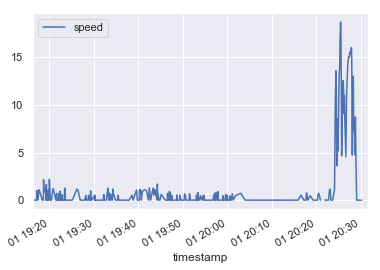

In [90]:
df_runs.loc[df_runs['split_1k'].idxmin()[0]][['speed']].plot()

In [97]:
agg_funcs = {'altitude': 'mean', 'cadence': 'mean', 'heart_rate': 'mean', 'distance': 'max', 'speed': 'mean'}
from shapely.geometry import LineString

def calc_aggregate_runs(df_runs, agg_funcs=agg_funcs):     
    gb = df_runs.groupby("id") 
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))   
    agg_values = gb.agg(agg_funcs).rename(columns={col: f"{col}_{func}" for col,func in agg_funcs.items()})

    ts = pd.DataFrame(gb.apply(lambda df: df.index.get_level_values(level=1)[0]), columns=['timestamp'])
    geometry = gpd.GeoDataFrame(gb.apply(lambda x: LineString(list(zip(x.x_latlon.dropna().values, x.y_latlon.dropna().values)))),
                                columns=['geometry_run'],
                                geometry='geometry_run',
                                crs = {'init': 'epsg:4326'}
                               ) 
    country = (gpd.sjoin(geometry, world[['name', 'geometry']], how='left', op='intersects')
               [[*geometry.columns.to_list(),*['name']]]
                )   
    return gpd.GeoDataFrame(pd.concat((agg_values,
                                       ts,
                                       country),
                                      axis=1), 
                            geometry='geometry_run',
                            crs = {'init': 'epsg:4326'}) 

def calc_personal_bests(df_runs): 
    longest =  df_runs['distance'].max()
    fastets_5k = df_runs.query('distance>=5000')[['cumulative_time_seconds']].min()/60
    fastests_10k = df_runs.query('distance>=10000')[['cumulative_time_seconds']].min()/60
    fastet_half_marathon= df_runs.query('distance>= 210975')[['cumulative_time_seconds']].min()/60
    fastet_marathon = df_runs.query('distance>= 2*210975')[['cumulative_time_seconds']].min()/60
    fastest_1k_split = df_runs['split_1k'].min()
    fastest_mile_split =  df_runs['split_1mile'].min()
    return fastest_1k_split


In [57]:
%%time
calc_personal_bests(df_runs)

Wall time: 32.8 ms


67.0

In [98]:
df_agg_runs = calc_aggregate_runs(df_runs, agg_funcs=agg_funcs)

In [8]:
%%time
idx_1k = ((test_run['distance']+1000).values[:,None]>test_run['distance'].values).astype(np.int64).argmin(axis=1)
cum_time = test_run['cum_time_seconds'].values
idx_1k = idx_1k[idx_1k>0]
(cum_time[idx_1k]-cum_time[np.arange(idx_1k.shape[0])]);

Wall time: 3.99 ms


# Visualize data

In [124]:
import folium

def plot_base_map(pos_init=[51.442302, 7.091737]): 
    return folium.Map(pos_init, zoom_start=14)

In [128]:
def plot_run(df_runs, id_, base_map=None): 
    df_run = df_runs.loc[[id_]]   
    m = base_map or plot_base_map([df_run.geometry_run.values[0].xy[1][0], df_run.geometry_run.values[0].xy[0][0]])
    folium.GeoJson(df_run['geometry_run']).add_to(m)
    #m.fit_bounds(m.get_bounds())
    return m 
    
m = plot_run(df_agg_runs,id_=45)
m.save('test.html')

## df_run.columns

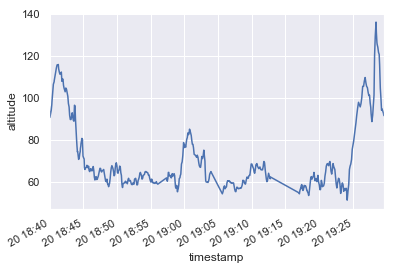

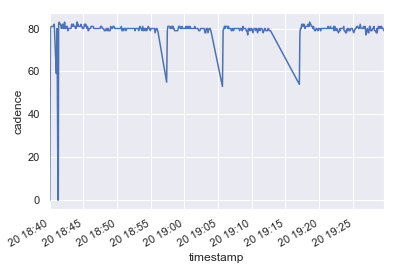

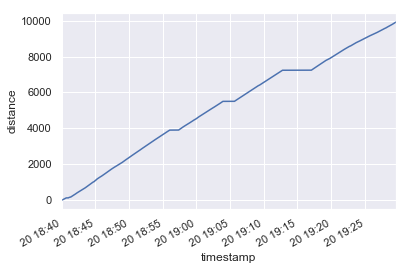

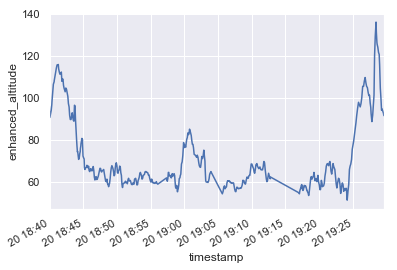

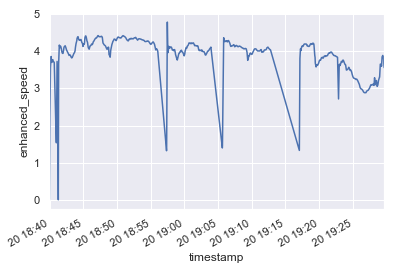

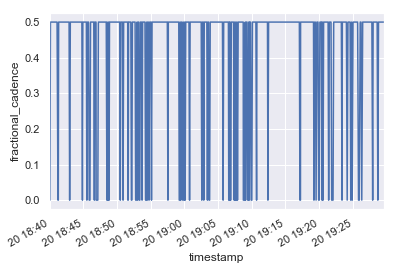

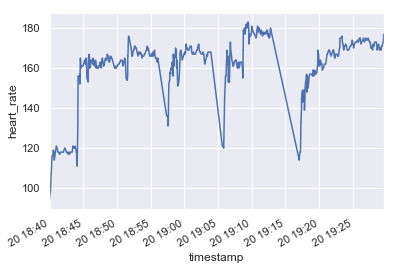

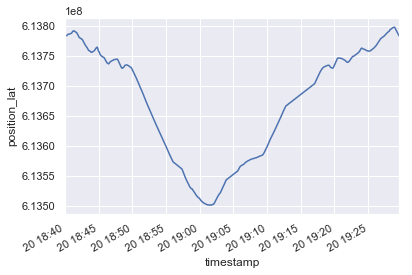

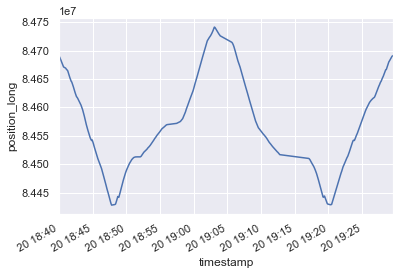

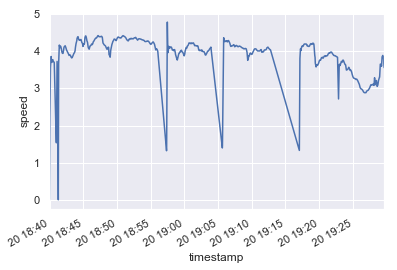

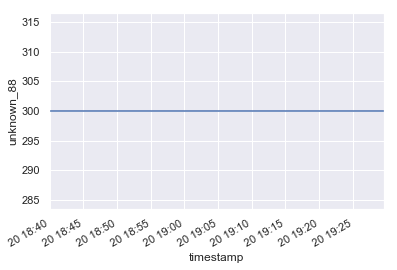

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
col_plot = df_run.columns
for col in col_plot: 
    f,ax = plt.subplots()
    df_run[col].plot()
    ax.set_ylabel(col)